In [2]:
#############################################################################
# zlib License
#
# (C) 2023 Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

## Imports

In [3]:
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from i2c_gui.chips.etroc2_chip import register_decoding
%matplotlib inline

## Set defaults

In [4]:
# 'If set, the full log will be saved to a file (i.e. the log level is ignored)'
log_file = False
# 'Set the logging level. Default: WARNING',
#  ["CRITICAL","ERROR","WARNING","INFO","DEBUG","TRACE","DETAILED_TRACE","NOTSET"]
log_level_text = "WARNING"
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "COM3"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

In [5]:
if log_file:
    logging.basicConfig(filename='logging.log', filemode='w', encoding='utf-8', level=logging.NOTSET)
    log_level = 0
else:
    log_level = 0
    if log_level_text == "CRITICAL":
        log_level=50
    elif log_level_text == "ERROR":
        log_level=40
    elif log_level_text == "WARNING":
        log_level=30
    elif log_level_text == "INFO":
        log_level=20
    elif log_level_text == "DEBUG":
        log_level=10
    elif log_level_text == "TRACE":
        log_level=8
    elif log_level_text == "DETAILED_TRACE":
        log_level=5
    elif log_level_text == "NOTSET":
        log_level=0
    logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

## Start logger and connect

In [6]:
logger = logging.getLogger("Script_Logger")

Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

## For FPGA connection (not yet fully implemented)
#conn.connection_type = "FPGA-Eth"
#conn.handle: FPGA_ETH_Helper
#conn.handle.hostname = "192.168.2.3"
#conn.handle.port = "1024"

conn.connect()

In [7]:
chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)  # Not needed if you do not access ETROC registers (i.e. only access WS registers)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers

logger.setLevel(log_level)

## Useful Functions

In [8]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

## Automatic threshold calibration

In [103]:
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))
# ACC_map_THCal= np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
# for row in [3,9]:
#     for col in [3,9]:
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        # time.sleep(15)    # This is may be needed to let calibration complete
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Fetch the status registers
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[15-row,15-col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[15-row,15-col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        # ACC_map_THCal[15-row,15-col]= pixel_decoded_register_read("ACC", "Status", need_int=True)
        # print("Pixel", row, col, "ACC", pixel_decoded_register_read("ACC", "Status"), "BL", pixel_decoded_register_read("BL", "Status"), "NW", pixel_decoded_register_read("NW", "Status"))


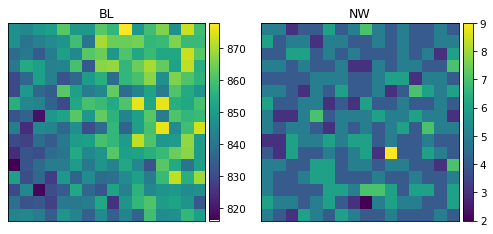

In [104]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax0 = fig.add_subplot(gs[0,1])
ax0.set_title("NW")
img0 = ax0.imshow(NW_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

## S-curve calibration

In [106]:
DAC_range = np.arange(int(0x340), int(0x375))
ACC_map_Scurve = {row:{col:np.zeros_like(DAC_range) for col in range(16)} for row in range(16)}
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
# for row in range(16):
#     for col in range(16):
scan_list = [5,7,12]
for row in scan_list:
    for col in scan_list:
        print("Pixel", row, col)
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        for index,DAC in enumerate(DAC_range):
            # Maybe required to make this work
            # pixel_decoded_register_write("enable_TDC", "0")
            # pixel_decoded_register_write("testMode_TDC", "0")
            # Enable THCal clock and buffer and bypass
            pixel_decoded_register_write("CLKEn_THCal", "1")
            pixel_decoded_register_write("BufEn_THCal", "1")
            pixel_decoded_register_write("Bypass_THCal", "1")
            # Reset the calibration block (active low)
            pixel_decoded_register_write("RSTn_THCal", "0")
            pixel_decoded_register_write("RSTn_THCal", "1")
            # Set the DAC value to the value being scanned
            pixel_decoded_register_write("DAC", format(DAC, '010b'))
            # Start and Stop the calibration, maybe pause for 1ms (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
            pixel_decoded_register_write("ScanStart_THCal", "1")
            # time.sleep(.1)
            pixel_decoded_register_write("ScanStart_THCal", "0")
            # Fetch the status registers
            if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
            ACC_map_Scurve[15-row][15-col][index] = pixel_decoded_register_read("ACC", "Status", need_int=True)


Pixel 5 5
Pixel 5 7
Pixel 5 12
Pixel 7 5
Pixel 7 7
Pixel 7 12
Pixel 12 5
Pixel 12 7
Pixel 12 12


## Comparing Auto-THCal with S-curve

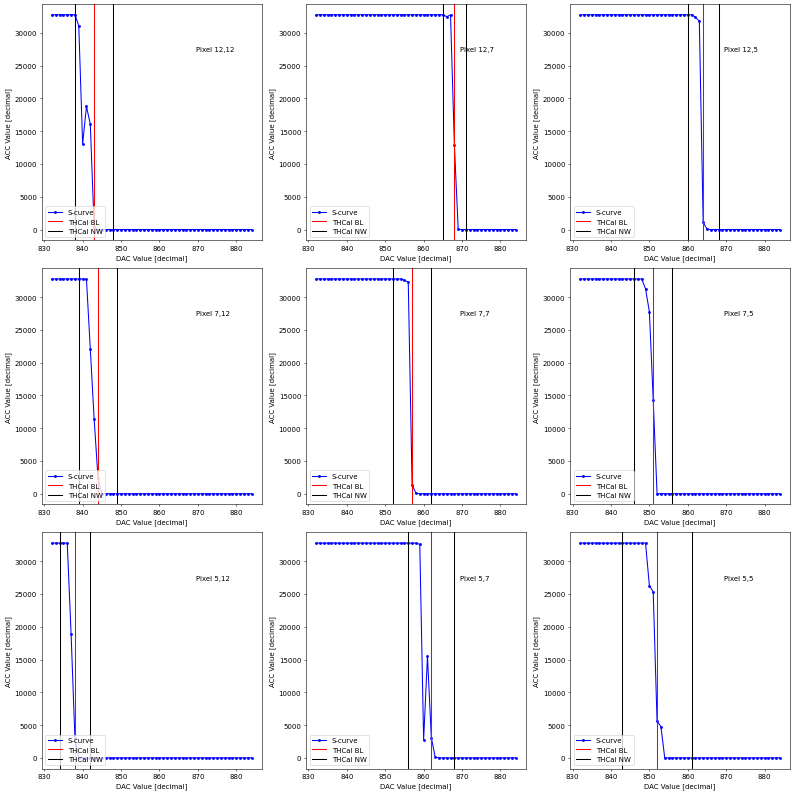

In [107]:
fig = plt.figure(dpi=50, figsize=(16,16))
gs = fig.add_gridspec(len(scan_list),len(scan_list))
for ri,row in enumerate(scan_list):
    for ci,col in enumerate(scan_list):
        ax0 = fig.add_subplot(gs[len(scan_list)-ri-1,len(scan_list)-ci-1])
        ax0.plot(DAC_range, ACC_map_Scurve[15-row][15-col], 'b.-', label="S-curve")
        ax0.axvline(BL_map_THCal[15-row][15-col], color='r', label="THCal BL")
        ax0.axvline(BL_map_THCal[15-row][15-col]+NW_map_THCal[15-row][15-col], color='k', label="THCal NW")
        ax0.axvline(BL_map_THCal[15-row][15-col]-NW_map_THCal[15-row][15-col], color='k')
        ax0.set_xlabel("DAC Value [decimal]")
        ax0.set_ylabel("ACC Value [decimal]")
        ax0.text(0.7, 0.8, f"Pixel {row},{col}", transform=ax0.transAxes)
        plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## PIxel ID check

In [9]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1


In [11]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

## Switch off booleans needed for calibration

## Disconnect chip

In [12]:
conn.disconnect()

: 